In [13]:
import numpy as np
import lmfit
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit
import matplotlib.pyplot as plt

from scipy.special import dawsn

%reload_ext autoreload
%autoreload 2

In [2]:
def V(frequency, time, harmonic=1, ReAmp=1, ImAmp=1):
    
    f = frequency
    t = time
    k = harmonic
    Vpk = ReAmp
    Vppk = ImAmp
    Vk = Vpk + 1j * Vppk
    Vmk = Vpk - 1j * Vppk
    
    signal = 0.5 * (Vk * np.exp(2 * np.pi * f * k * 1j * t) +
                    Vmk * np.exp(-2 * np.pi * f * k * 1j * t))
    
    return signal

def GaussWindow(signal, frequency, time, window_param):
    """Applies a gaussian windowing function to a time-domain signal
    
    Parameters
    ----------
    signal : np.ndarray
        Time domain array of signal to be windowed
        
    frequency : float
        Fundamental frequency of the signal
        
    time : np.ndarray
        Array of timestamps corresponding to signal samples
        
    window_param : float
        Defines decay length of window function. Corresponds to number of
        waveforms at the signals frequency.
    
    Returns
    -------
    WinSig : np.ndarray
        Time domain array of signal with window function applied."""
    f = frequency
    t = time
    b = window_param
    
    W = np.exp((-f**2 * t**2) / b**2)
    WinSig = W * signal
    
    return WinSig

def GaussFFT(frequency, sig_frequency, window_param, harmonic=1):
    
    w = 2 * np.pi * frequency
    w_tilde = 2 * np.pi * sig_frequency
    b = window_param
    k = harmonic
    
    G_k = (b * np.sqrt(np.pi) / w_tilde) \
    * np.exp((-(w - k * w_tilde)**2 * np.pi**2 * b**2) / w_tilde**2)
    
    return G_k


def DawsonFFT(frequency, sig_frequency, window_param, harmonic=1):
    
    w = 2 * np.pi * frequency
    w_tilde = 2 * np.pi * sig_frequency
    b = window_param
    k = harmonic
    
    x = ((w - k * w_tilde) * np.pi * b) / w_tilde
    
    D_k = dawsn(x) * (b / w_tilde *2)
    
    return D_k


def V_FFT(frequency, sig_frequency, window_param, harmonic=1, ReAmp=1, ImAmp=1):
    
    f = frequency
    f_tilde = sig_frequency
    w = 2 * np.pi * frequency
    w_tilde = 2 * np.pi * sig_frequency
    b = window_param
    k = harmonic
    
    Vpk = ReAmp
    Vppk = ImAmp
    
    Gpk = GaussFFT(f, f_tilde, b, k)
    Gnk = GaussFFT(f, f_tilde, b, -k)
    Dpk = DawsonFFT(f, f_tilde, b, k)
    Dnk = DawsonFFT(f, f_tilde, b, -k)
    
    V_hat = 0.5 * (Vpk * (Gpk + Gnk) + Vppk * (Dpk - Dnk)) \
    + 1j / 2 * (Vppk * (Gpk - Gnk) + Vpk * (-Dpk - Dnk))

    return V_hat

In [20]:
freq = 1
Ns = 4096
Wfm = 100
k = 1
b = 10

t_fin = Wfm / freq
fs = Ns / (t_fin)
df = 1 / t_fin

t = np.linspace(0, t_fin, num=Ns)
dat = V(freq, t)
unit = np.ones(dat.shape)

window = GaussWindow(unit, 0.5, t, b)
windat = GaussWindow(dat, 0.5, t, b)

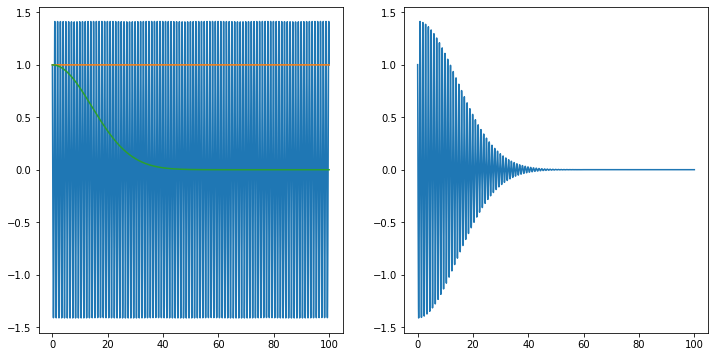

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1.plot(t, dat.real)
ax1.plot(t, unit)
ax1.plot(t, window)

ax2.plot(t, windat.real)
plt.show()

In [22]:
w_list = np.linspace(-fs/2, fs/2-df, Ns)

Gpk = GaussFFT(w_list, freq, b, k)
Gnk = GaussFFT(w_list, freq, b, -k)
Dpk = DawsonFFT(w_list, freq, b, k)
Dnk = DawsonFFT(w_list, freq, b, -k)

Vf = V_FFT(w_list, freq, b, k, ReAmp=1, ImAmp=1)

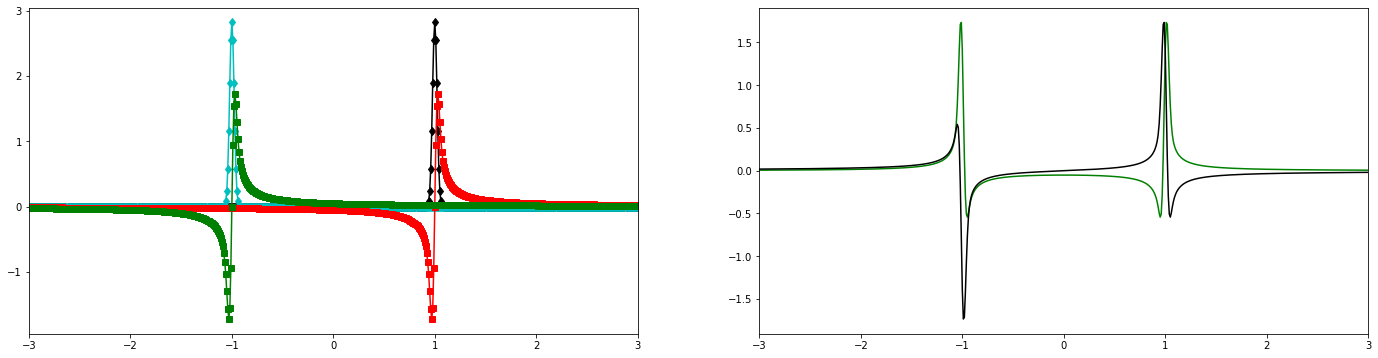

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24,6))

ax1.plot(w_list, Gpk, 'k-d')
ax1.plot(w_list, Gnk, 'c-d')
ax1.plot(w_list, Dpk, 'r-s')
ax1.plot(w_list, Dnk, 'g-s')
ax1.set_xlim(-3 * freq, 3 * freq)

# ax2.plot(w_list, Vf.real, 'k')
ax2.plot(w_list, Vf.real, 'g')
ax2.plot(w_list, Vf.imag, 'k')
ax2.set_xlim(-3 * freq, 3 * freq)

plt.show()

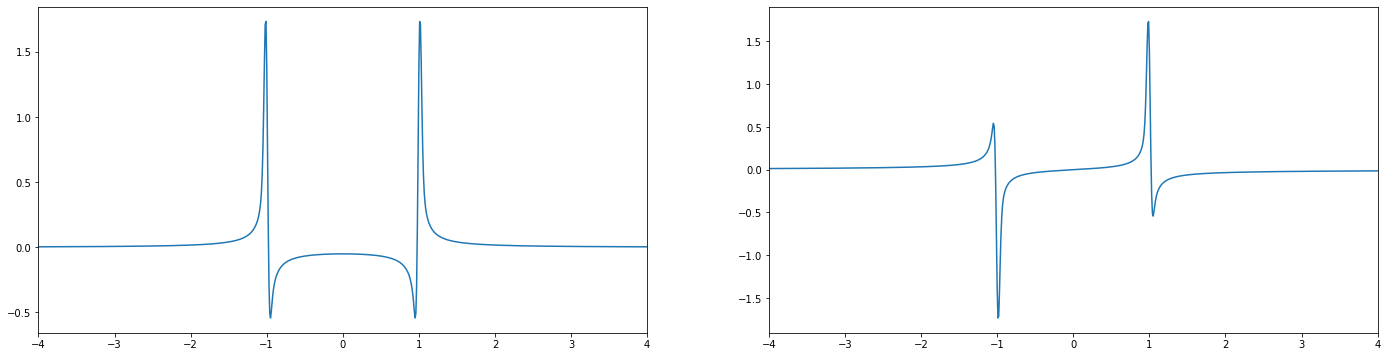

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24,6))

ax1.plot(w_list, Vf.real)
ax1.set_xlim(-4*freq, 4*freq)

ax2.plot(w_list, Vf.imag)
ax2.set_xlim(-4*freq, 4*freq)

plt.show()

In [26]:
freqs = np.fft.fftshift(np.fft.fftfreq(Ns,1/fs))
datfft = np.fft.fftshift(np.fft.fft(windat))

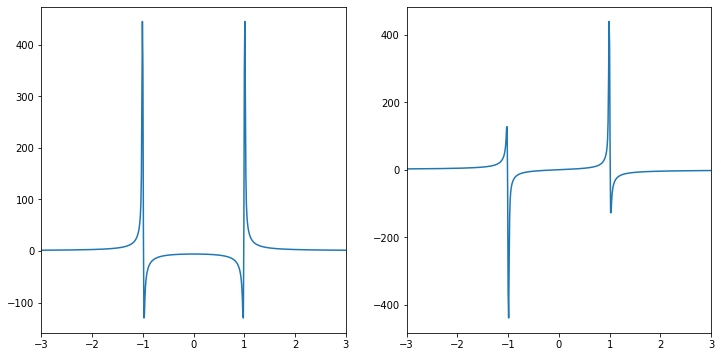

In [31]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1.plot(freqs, datfft.real)
ax1.set_xlim(-3*freq, 3*freq)

ax2.plot(freqs, datfft.imag)
ax2.set_xlim(-3*freq, 3*freq)

plt.show()

In [32]:
import lmfit

In [33]:
class SignalModel(lmfit.model.Model):
    
    def __init__(self, *args, **kwargs):
        super(SignalModel, self).__init__(V_FFT, *args, **kwargs)
        

In [34]:
Signal1 = SignalModel()

in

In [ ]:
Signal1.fit(datfft, )